# Códigos para Plotar Informações de Qualidade do Ar
## Plotando Jan-d04 
## Opções EDGAR

In [1]:
import pandas as pd
from netCDF4 import Dataset
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import seaborn as sns
import datetime as dt
%matplotlib inline

## *Entradas*
* Selecionar arquivos de origem para preparar figuras.
* Inicializar variáveis para figuras.

### Parametrização dos arquivos de entrada

Ajustar diretório que contem os arquivos, nomes de rodadas, e shapefiles a serem plotados

In [2]:
directory = str('D:/Mestrado/1.Resultados/QualidadedoAr/')
wrfdir = str('D:/Mestrado/1.Resultados/Meteorologia/')
mes   = ['jan','jul']
grade = ['d01_27km','d02_9km','d03_3km','d04_1km']
data  = ['20150109','20150724']
datawrf  = ['01-09','07-24']
modelagens = ['-','-20I-20T']#'-20I','-20T']
#modelagens  = ['_PT_ED-100I','_PT-20_ED-100I', '_PT-20_ED-100I-20T', '_PT_ED-100I-20T']
shapes = ['pirashape','RMSP']
spinup = 48
run_len = 24*7

## Abrir arquivos COMBINE ACONC e DEP

In [10]:
aconc = []
#dep=[]
for m in modelagens:
    aconc.append(xr.open_dataset(directory+mes[0]+'.'+grade[3]+m+'/COMBINE_ACONC_v521_intel_pira_riz_nudge_'+
                        mes[0]+'_'+data[0]+'.nc'))
    #dep.append(xr.open_dataset(directory+mes[0]+'.'+grade[3]+m+'/COMBINE_DEP_v521_intel_pira_riz_nudge_'+
    #                    mes[0]+'_'+data[0]))

## Abrir arquivo WRF para buscar valores de LAT / LON


In [5]:
nc_wrf = Dataset(wrfdir+'arqWRF/'+mes[0]+'/wrf_fnl_pira_pedruzzi2016_nudge_'+
                 mes[0]+'/wrfout_'+grade[3][:3]+'_2015-'+datawrf[0]+'_00%3A00%3A00')

## Preparar coordenadas para XArray
* DATAS
* ALTITUDE
* LATITUDE
* LONGITUDE

In [6]:
# DATAS
dates = []
dates = [dt.datetime.strptime(str(aconc[0].attrs['SDATE']),'%Y%j')]
for i in range(1,aconc[0].dims['TSTEP']):
    dates.append(dates[0]+dt.timedelta(hours=i))

# LATITUDE
# LONGITUDE
croplat = int((nc_wrf.dimensions['south_north'].size-aconc[0].dims['ROW'])/2)
croplon = int((nc_wrf.dimensions['south_north'].size-aconc[0].dims['ROW'])/2)
lats      = nc_wrf.variables['XLAT'][0,croplat:-croplat,croplat:-croplat]
longs     = nc_wrf.variables['XLONG'][0,croplon:-croplon,croplon:-croplon]

# PLOT CORNERS
llcrnrlon = np.min(longs)      #longitude of lower left hand corner of the selected map domain.
llcrnrlat = np.min(lats)       #latitude of upper right hand corner of the desired map domain (degrees).
urcrnrlon = np.max(longs)      #longitude of upper right hand corner of the selected map domain.
urcrnrlat = np.max(lats)      #latitude of upper right hand corner of the selected map domain.

coordlat  = np.linspace(llcrnrlat,urcrnrlat,num=aconc[0].dims['ROW'])
coordlon  = np.linspace(llcrnrlon,urcrnrlon,num=aconc[0].dims['COL'])

# ADJUSTMENTS
for a in aconc:
    a.coords['TSTEP'] = dates
    a.coords['ROW'] = coordlat
    a.coords['COL'] = coordlon
    a.rename({'ROW': 'LAT', 'COL': 'LON'}, inplace=True)
    for var in a.variables:
        if 'units' in a.variables[var].attrs:
            if a.variables[var].attrs['units'].split() != []:
                a.variables[var].attrs['units'] = a.variables[var].attrs['units'].split()[0]

for i in range(0,len(aconc)):
    aconc[i] = aconc[i].isel(TSTEP=slice(spinup,spinup+run_len))
weekd=[]
for d in aconc[0].TSTEP.dt.weekday:
    if d < 5:
        weekd.append('Weekday')
    else:
        weekd.append('Weekend')

## Figuras por poluente

### Selecionar parâmetro em *param*

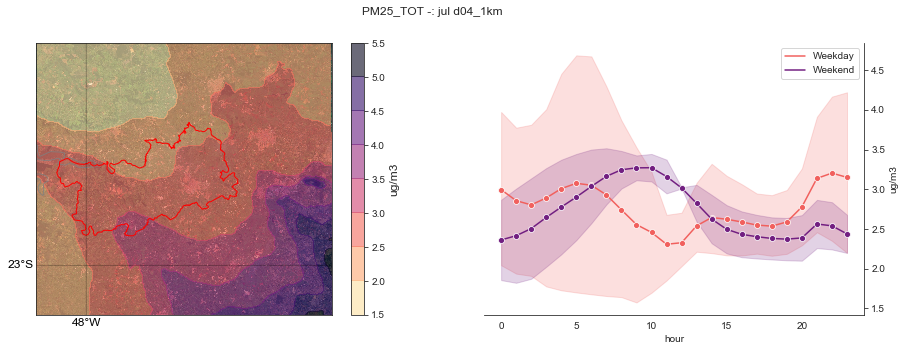

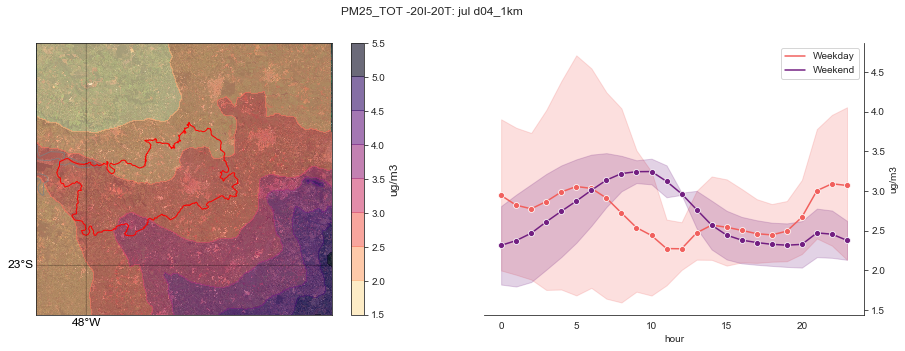

In [13]:
param = 'PM25_TOT'
mesplt = mes[1]
gradeplt = grade[3]
for i in range(0, len(aconc)):
# PLOT COLORMAP
    fig, axes = plt.subplots(ncols=2, figsize=(15,5)) #gridspec_kw = {'width_ratios':[2, 1]})
    fig.suptitle(param+' '+modelagens[i]+': '+mesplt+' '+gradeplt, fontsize=12)
    map = Basemap(epsg=4326,              #EPSG code defining projection 
                llcrnrlon=llcrnrlon,      #longitude of lower left hand corner of the selected map domain.
                llcrnrlat=llcrnrlat,      #latitude of upper right hand corner of the desired map domain (degrees).
                urcrnrlon=urcrnrlon,      #longitude of upper right hand corner of the selected map domain.
                urcrnrlat=urcrnrlat,      #latitude of upper right hand corner of the selected map domain.
                resolution='h',           #resolution of boundary dataset being used (c for crude, l for low, etc.). If None, no boundary dataset is associated with the Basemap instance.
                projection='lambert',     #map projection. Print the module variable supported_projections to see a list of allowed values
                ellps = 'WGS84',          #string describing ellipsoid (‘GRS80’ or ‘WGS84’, for example). If both rsphere and ellps are given, rsphere is ignored. Default None. See pyproj.pj_ellps for allowed values.
                lat_0=lats.mean(),        #center of desired map domain (in degrees). 
                lon_0=longs.mean(),       #center of desired map domain (in degrees).
                ax=axes[0])           
    paramplot = map.contourf(longs,       #X specify the (x) coordinates of the surface
                    lats,                 #Y specify the (y) coordinates of the surface
                    np.squeeze(aconc[i][param][:,0,:,:].mean(dim='TSTEP')), 
                    antialiased = False,
                    cmap=plt.cm.magma_r,
                    alpha=0.6)#,
                    #vmin=0,
                    #vmax=int(np.ceil(aconc[0][param][:,0,:,:].max())),
                    #levels=np.arange(0,int(np.ceil(aconc[0][param][:,0,:,:].max()))))
## DRAW COAST, COUNTRY, STATES, PARALLELS, MERIDIANS
    map.drawcoastlines(linewidth=0.75, color='gray')
    #map.drawcountries(linewidth=1.0)
    map.drawstates(linewidth=1.0, color='gray')
    map.drawparallels(np.arange(-80., 81., 1), labels=[1,0,0,0], fontsize=12, linewidth=0.5)       
    map.drawmeridians(np.arange(-180., 181., 1), labels=[0,0,0,1], fontsize=12, linewidth=0.5)
    #map.fillcontinents(color='coral',lake_color='aqua')
    #map.drawlsmask(land_color='Linen', ocean_color='#CCFFFF') 
## PLOT SHAPEFILES
    for s in shapes:
        map.readshapefile(wrfdir+'arqShape/'+s, s, color='r', linewidth=1.0) #Plot shapefile
## MAP ARCGIS
    map.arcgisimage(service='ESRI_Imagery_World_2D', xpixels = 1500, verbose= False, alpha=1.0)
## COLORBAR
    cbar = fig.colorbar(paramplot, ax=axes[0]) # Plot Colorbar
    cbar.set_label(aconc[i].variables[param].attrs['units'], fontsize = 12, rotation=90)
    cbar.ax.tick_params(labelsize = 10)
## TITLE FOR SUBPLOT
    #axes[0].set_title(param)
# PLOT LINEPLOT
    sns.set_style('white')
    sns.despine(right=False, left=True, ax=axes[1])
    sns.lineplot(x=aconc[i].TSTEP.dt.hour, y=aconc[i].variables[param][:,0,:,:].mean(dim=['LAT', 'LON']), 
                           hue=weekd, hue_order=['Weekday','Weekend'], palette='magma_r', marker='o', ax=axes[1])
    axes[1].set_ylabel(aconc[i].variables[param].attrs['units'])
    axes[1].yaxis.set_ticks_position('right')
    axes[1].yaxis.set_label_position('right')

## Plots comparativos

### Selecionar parâmetro em *param*

In [7]:
param = 'O3_UGM3'
paramdic = {}
for i in range(0,len(modelagens)):
    paramdic[modelagens[i]] = aconc[i].variables[param].values.flatten()
paramdf = pd.DataFrame(paramdic)
paramdic=[]

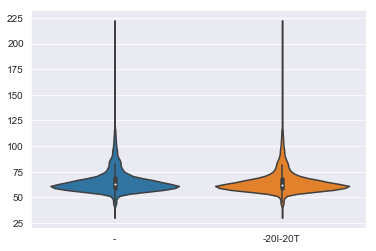

In [8]:
sns.set_style('darkgrid')
sns.violinplot(data=paramdf)

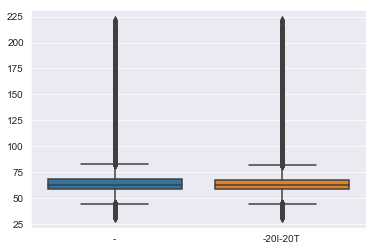

In [9]:
sns.boxplot(data=paramdf)

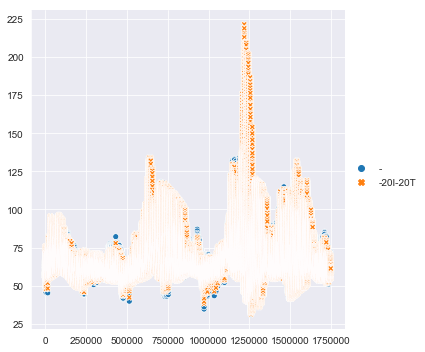

In [10]:
sns.relplot(data=paramdf)

In [ ]:
sns.scatter(data=paramdf)